# Cryptocurrency Swing Trading
We have become aware of a niche opportunity among stablecoins traded on decentralized exchanges. We've been tasked with building the logic for a trading bot that will maximize profit from trading these swings. Stablecoins are crypto assets that are intended to hold their price at a specified level (at 1 USD in the case of DAI and USDC). While there is some volatility, the price movement of this trading pair seems to be generally predictable. While these price movements are certainly not new, in the past, fees have made these transactions prohibitively expensive. With the advent of decentralized exchange aggregators, liquidity pools are used to service trades rather than the traditional order books. The aggregator allows users to find the exchange/liquidity pool with the best price and is able to keep fees at a nominal rate, which opens the door for traders to now capitalize on these spots. We do need to account for slippage, typically the price to buy an asset is (almost) always higher than the price to sell. For now, we are only focusing on the stablecoin trading pair of DAI and USDC. Because the prices are aggregated among many exchanges, price history is not readily available. We'll need to accumulate our own data to visualize the price history.  

For now, our data has been pulled via API into google sheets. This is not an efficient way to store data and we have set up a direct API moving forward, however, we will review the data that we have collected thus far.



In [23]:

import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import pickle
import os.path
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
from heapq import nlargest
% matplotlib notebook

# API pull from google sheet
def gsheet_api_check(SCOPES):
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)
    return creds

    from googleapiclient.discovery import build

def pull_sheet_data(SCOPES,SPREADSHEET_ID,RANGE_NAME):
    creds = gsheet_api_check(SCOPES)
    service = build('sheets', 'v4', credentials=creds)
    sheet = service.spreadsheets()
    result = sheet.values().get(
        spreadsheetId=SPREADSHEET_ID,
        range=RANGE_NAME).execute()
    values = result.get('values', [])
    
    if not values:
        print('No data found.')
    else:
        rows = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                                  range=RANGE_NAME).execute()
        data = rows.get('values')
        print("COMPLETE: Data copied")
        return data

# Pulls data from the entire spreadsheet tab
RANGE_NAME = 'Sheet1!A1:B6000'

SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
SPREADSHEET_ID = '12vl9HzPGpi2uGPdUefdqIBa8tyqsxk61MGLMqLn0Qz8'

data = pull_sheet_data(SCOPES,SPREADSHEET_ID,RANGE_NAME)
dai = pd.DataFrame(data[0:], columns=['price','date'])

UsageError: Line magic function `%` not found.


## Data Cleaning

In [24]:
# Reorder cols
dai = dai[['date', 'price']]

# Drop NA
dai = dai.dropna(axis=0)

# Format dtypes
dai['date'] = pd.to_datetime(dai['date'], format = '%m/%d/%Y %H:%M:%S')

# The API request should happen every 5 minutes, but sometimes the calls are off schedule and those can be removed
# Add temp minute col to find minutes that are off schedule (minutes not ending in 8 or 3) and remove
dai['minute'] = dai['date'].dt.minute.astype(str)
dai['minute'] = [x[-1] for x in dai['minute']]
dai = dai[dai['minute'].isin(['3','8'])].reset_index(drop=True)

# Remove duplicates by only keeping rows with more than 4 minutes between entries
dai['date_shift'] = dai['date'].shift(1)
filtered_dai = dai[pd.to_timedelta(dai['date'] - dai['date_shift']) > pd.to_timedelta('4 minutes')].reset_index(drop=True)

# 1st index is incorrectly dropped because of NA resulting from shift, add back 1st row and reassign
dai = pd.concat([pd.DataFrame(dai.loc[0]).T, filtered_dai]).reset_index(drop=True)
dai = dai[['date','price']]

# Formatting lost from merge, re-format
dai['date'] = pd.to_datetime(dai['date'], format = '%m/%d/%Y %H:%M:%S')
dai['price'] = dai['price'].astype(float)

# The dollar is missing from the price for all entries, add back in
dai['price'] = dai['price'] + 1

Text(0, 0.5, 'Price of DAI in USDC')

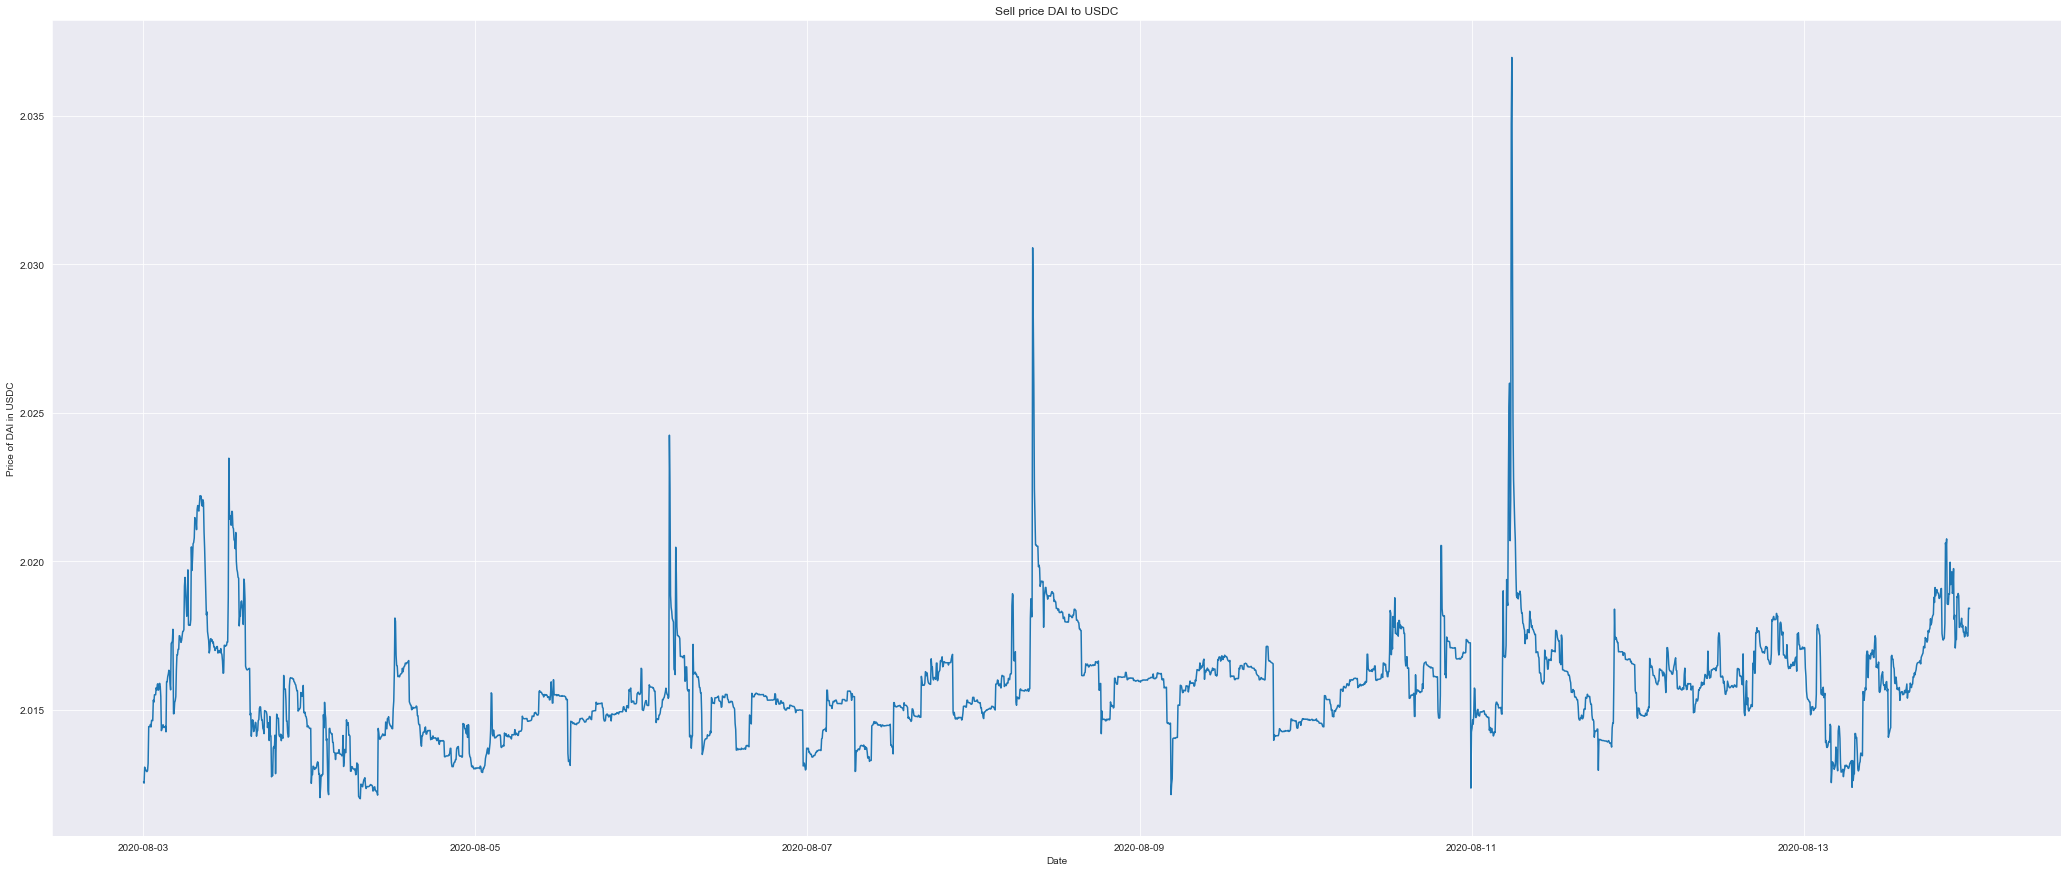

In [25]:
# Isolate timeframe of interest
dai = dai[(dai['date'] >= '2020-08-03') & (dai['date'] <= '2020-08-14')]

# Plot time series
sns.set_style('darkgrid')
plt.figure(figsize=(36, 15))
#test = create_boundaries(august_only, .0015, 2.5)
ax = sns.lineplot('date','price', data = dai)
ax.set_title("Sell price DAI to USDC")
ax.set_xlabel("Date")
ax.set_ylabel("Price of DAI in USDC")




Now that our data is in order let's look at a simple timeseries plot of the price to date. Cryptocurrencies are known for moving pretty quickly, however, we only have ten days of data to train on at the moment. In the interest of getting a model into production ASAP, we will use this data to establish a foundation. Going forward, we will constantly need to re-evaluate our model to prevent overfitting to our miniscule dataset.  Note this is the price in USDC to sell DAI. Our goal is to successfully trade these swings. Ideally we hold DAI before a quick large spike up, sell for USDC at the peak, and buy DAI back again at the low point. We will investigate strategies to maximize profits. 

First off, we suspect that prices are more liekly to spike up when they are in a below average state, and more likely to drop when in an above average state. These large, quick movements offer the best opportunity to capitalize on price swings. We will use the interquartile range to split the data into three sections and test our theory.



In [18]:
# Investigate Swings
swings = dai.copy()

# Use historic average as cutoff
cutoff = swings['price'].mean()

# Set how large you want to account for on spikes and drops
spike_size = .003

# Shift sell price so we can compare obs next to each other
swings['sell_shifted'] = swings['price'].shift(1)

# Mark price tier lo, mid, or hi, and shift so we can check if it came from a different zone
swings['hi_price'] = (swings['price'] > cutoff).astype(int)
swings['hi_price_shifted'] = swings['hi_price'].shift(1)

swings['lo_price'] = (swings['price'] <= cutoff).astype(int)
swings['lo_price_shifted'] = swings['lo_price'].shift(1)

# Filter dataframe for hi prices only or entries where the previous price was hi (just dropped)
hi_prices = swings[(swings['hi_price'] == 1) | (swings['hi_price_shifted'] == 1)]

# Filter dataframe for hi prices only or entries where the previous price was hi 
hi_prices['big_spike'] = np.where((hi_prices['price'] - hi_prices['sell_shifted'] > spike_size) & (hi_prices['hi_price_shifted'] == 1), 1, 0)
hi_prices['big_drop'] = np.where((hi_prices['price'] - hi_prices['sell_shifted'] < -spike_size) & (hi_prices['hi_price_shifted'] == 1), 1, 0)


# Filter dataframe for lo prices only or entries where the previous price was lo
lo_prices = swings[(swings['lo_price'] == 1) | (swings['lo_price_shifted'] == 1)]

# Tally spikes and drops, making sure that the price the spike originated form was lo
lo_prices['big_spike'] = np.where((lo_prices['price'] - lo_prices['sell_shifted'] > spike_size) & (lo_prices['lo_price_shifted'] == 1), 1, 0)
lo_prices['big_drop'] = np.where((lo_prices['price'] - lo_prices['sell_shifted'] < -spike_size) & (lo_prices['lo_price_shifted'] == 1), 1, 0)

# Display df showing spikes/drops by price zone
pd.DataFrame({'Total Spikes': [lo_prices['big_spike'].sum(),
                         hi_prices['big_spike'].sum()],
              'Total Drops': [lo_prices['big_drop'].sum(),
                        hi_prices['big_drop'].sum()]}, index = ['Lo Price','Hi Price'])

,Total Spikes,Total Drops
Lo Price,4,0
Hi Price,5,5


Granted our data is limited, but so far there does seem to be some truth to our hypothesis. The price only took significant drops when in the 'Hi Price' tier. Let's plot these swings to get a better vizual representation.

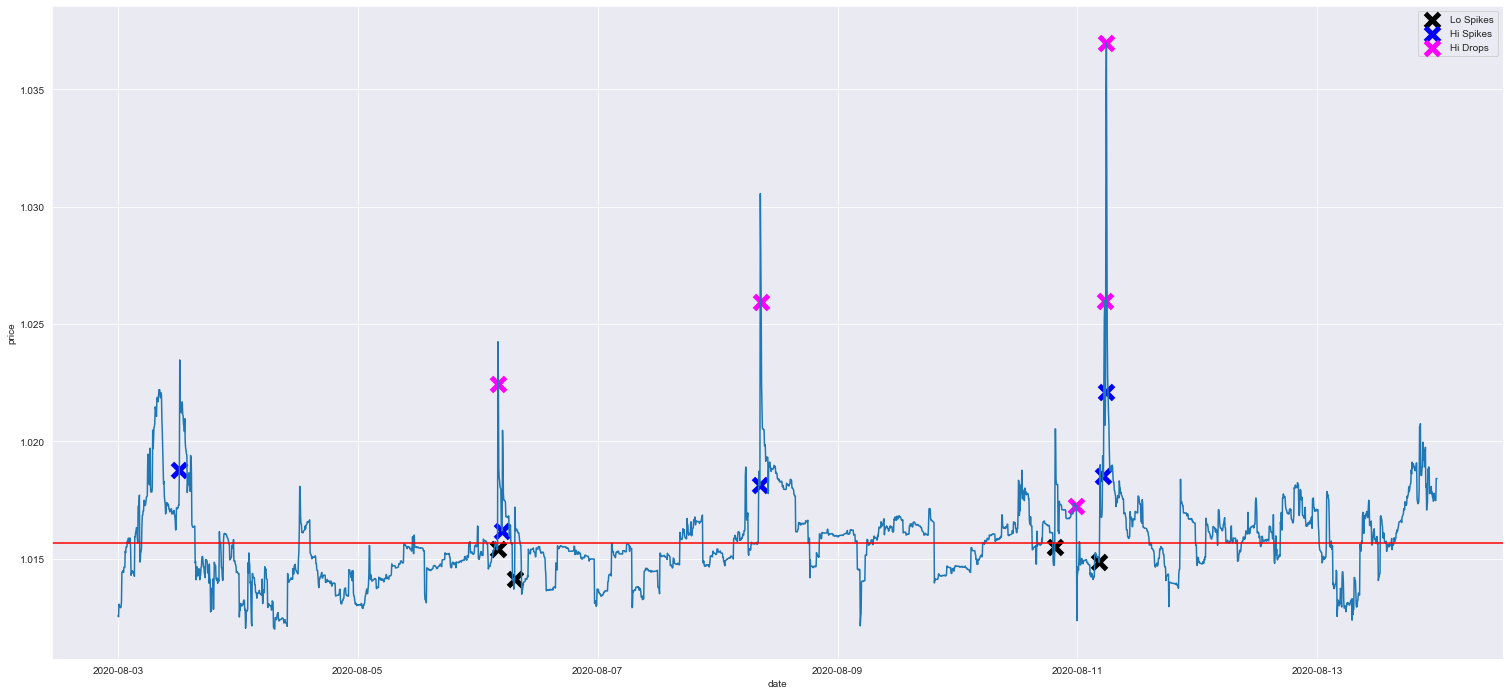

In [21]:
# Retrieve the index previous to all spikes/drops (where the spike/drop originated from) to plot 
lo_spikes = [x - 1 for x in lo_prices[lo_prices['big_spike']==1].index]
lo_drops = [x - 1 for x in lo_prices[lo_prices['big_drop']==1].index]

hi_spikes = [x - 1 for x in hi_prices[hi_prices['big_spike']==1].index]
hi_drops = [x - 1 for x in hi_prices[hi_prices['big_drop']==1].index]

# Plot time series
plt.figure(figsize=(26, 12))
ax = sns.lineplot('date','price', data = dai)
# Plot avg
ax.axhline(cutoff, c='r')
# Plot all spikes/drops
sns.scatterplot('date', 'price', data = dai.loc[lo_spikes], marker = 'x', color='black', s=200, alpha=1, linewidth=5, label = 'Lo Spikes')
sns.scatterplot('date', 'price', data = dai.loc[lo_drops], marker = 'x', color='darkmagenta', s=200, alpha=1, linewidth=5, label = 'Lo Drops')
sns.scatterplot('date', 'price', data = dai.loc[hi_spikes], marker = 'x', color='blue', s=200, alpha=1, linewidth=5, label = 'Hi Spikes')
sns.scatterplot('date', 'price', data = dai.loc[hi_drops], marker = 'x', color='magenta', s=200, alpha=1, linewidth=5, label = 'Hi Drops')
ax.legend()



Our limited data signifies that the higher the price is, the higher the likelihood of a large drop and the lower the price, the higher the likelihood of a large up tick. This is promising for our hypothesis and overall strategy, however, small sample size aside, there are other considerations. Our trader needs to have the proper token in hand to capitalize on the swings. For example, if we begin with DAI on 8/3/20, we can't capitalize on the immediate big spike up in price because we have no DAI to sell. If we attempt to hold both assets, we would convert more swings, however we would have to risk far less on each trade, which eats into profits. We would be best off if we could divise a system that 'knows' when to hold each currency. Going off of our hypothesis and findings, generally speaking we want to be holding DAI when the price is in the lo - mid range, looking for those spike ups so we can sell. Conversely, when the price is already high, we want to have USDC in hand ready to sell when the price regresses to the mean.

Up until now, we have only been using the price (in USDC) of selling DAI. We need to include the buying price. Our API will pick this up in the future, but for now we can estimate slippage (the gap between buy price and sell price) at approximately .002. Once we have the buy price data, we will also be able to detect pure arbitrage spots. There are times when the we are able to sell DAI and instantly buy it back cheaper or buy DAI and instantly sell it for more using the decentralized exchange aggregator, which results in instant risk-free profit (after we account for transactions costs). 

In the timeseries above, we chose a somewhat arbitrary amount to classify a 'big swing'. Going forward we will use moving averages to trigger our trades. When the price crosses our specified boundaries, we can trigger a trade event. As we'll see, these boundaries can also be dynamic and independent of each other, shrinking and growing as the prices move through different levels.



In [66]:
def create_framework(df, slippage, sell_moving_avg_type, buy_moving_avg_type, sell_moving_avg_hrs, buy_moving_avg_hrs, above_avg_upper_bound, above_avg_lower_bound, below_avg_upper_bound, below_avg_lower_bound):
    '''
    df: df of dates and sell prices
    slippage: gap between buy/sell price
    moving_avg_type: "simple", "exponential", or "median"
    sell_moving_avg_hrs: num hours to base moving average on for sell price
    buy_moving_avg_hrs: num hours to base moving average on for buy price
    above_avg_upper_bound: when the price is above average, what is our max threshold to sell (distance above buy price moving average)
    above_avg_lower_bound: when the price is above average, what is our threshold to buy (distance below sell price moving average)
    below_avg_upper_bound: when the price is below average, what is our threshold to sell (distance above buy price moving average)
    below_avg_lower_bound: when the price is below average, what is our threshold to buy (distance below sell price moving average)

    Output: adds buy price to df accounting for slippage, sets boundaries for various price levels to initiate trades
    '''
    # Work on copy of df
    df2 = df.copy()

    # split price cols into buy and sell side using slippage
    df2.columns = ['date','sell_price']
    df2['buy_price'] = df2['sell_price'] + slippage

    # How many 5 minute intervals
    sell_moving_avg_interval = int(round(sell_moving_avg_hrs * 60 / 5, 0))
    buy_moving_avg_interval = int(round(buy_moving_avg_hrs * 60 / 5, 0))
    
    # Set sell moving average
    if sell_moving_avg_type == 'simple':
        # Simple moving avg
        df2['moving_avg_mid_sell'] = df2['sell_price'].rolling(sell_moving_avg_interval).mean()

    elif sell_moving_avg_type == 'exponential':
        df2['moving_avg_mid_sell'] = df2['sell_price'].ewm(span=sell_moving_avg_interval, min_periods=sell_moving_avg_interval).mean()

    elif sell_moving_avg_type == 'median':
        df2['moving_avg_mid_sell'] = df2['sell_price'].rolling(sell_moving_avg_interval).median()
    else:
        raise ValueError("Moving average types: 'simple', 'exponential', 'median'")

    # Set buy moving average
    if buy_moving_avg_type == 'simple':
        # Simple moving avg
        df2['moving_avg_mid_buy'] = df2['buy_price'].rolling(buy_moving_avg_interval).mean()

    elif buy_moving_avg_type == 'exponential':
        df2['moving_avg_mid_buy'] = df2['buy_price'].ewm(span=buy_moving_avg_interval, min_periods=buy_moving_avg_interval).mean()

    elif buy_moving_avg_type == 'median':
        df2['moving_avg_mid_buy'] = df2['buy_price'].rolling(buy_moving_avg_interval).median()
    else:
        raise ValueError("Moving average types: 'simple', 'exponential', 'median'")

    # Scale price features
    historic_avg_buy_price = df2['buy_price'].mean()
    historic_avg_sell_price = df2['sell_price'].mean()
    price_is_hi_mask = df2['buy_price'] > historic_avg_buy_price
    price_is_lo_mask = df2['sell_price'] <= historic_avg_sell_price

    # Get the min max scaling for buy and sell prices, using a range from min price to mean for lo prices and mean to max price for hi prices
    df2.loc[price_is_hi_mask, 'sell_price_scaled'] = (df2.loc[price_is_hi_mask, 'sell_price'] - df2.loc[price_is_hi_mask, 'sell_price'].min()) / (df2.loc[price_is_hi_mask, 'sell_price'].max() - df2.loc[price_is_hi_mask, 'sell_price'].min())
    df2.loc[price_is_hi_mask, 'buy_price_scaled'] = (df2.loc[price_is_hi_mask, 'buy_price'] - df2.loc[price_is_hi_mask, 'buy_price'].min()) / (df2.loc[price_is_hi_mask, 'buy_price'].max() - df2.loc[price_is_hi_mask, 'buy_price'].min())
    df2.loc[price_is_lo_mask, 'sell_price_scaled'] = (df2.loc[price_is_lo_mask, 'sell_price'] - df2.loc[price_is_lo_mask, 'sell_price'].min()) / (df2.loc[price_is_lo_mask, 'sell_price'].max() - df2.loc[price_is_lo_mask, 'sell_price'].min())
    df2.loc[price_is_lo_mask, 'buy_price_scaled'] = (df2.loc[price_is_lo_mask, 'buy_price'] - df2.loc[price_is_lo_mask, 'buy_price'].min()) / (df2.loc[price_is_lo_mask, 'buy_price'].max() - df2.loc[price_is_lo_mask, 'buy_price'].min())

    # Set up boundary trigger points
    # Price is hi - dynamic boundaries
    # This makes sure that the min price has a upper bound equal to the below avg upper bound and when price is max, upper bound equals the upper bound input 
    df2.loc[price_is_hi_mask, 'upper_bound'] = df2.loc[price_is_hi_mask, 'moving_avg_mid_buy'] + below_avg_upper_bound - (below_avg_upper_bound - above_avg_upper_bound) * df2.loc[price_is_hi_mask, 'buy_price_scaled']  

    # This makes sure that the min price has a lower bound equal to the below avg lower bound and when price is max, lower bound equals the lower bound input 
    df2.loc[price_is_hi_mask, 'lower_bound'] = df2.loc[price_is_hi_mask, 'moving_avg_mid_sell'] - below_avg_lower_bound + (below_avg_lower_bound - above_avg_lower_bound) * df2.loc[price_is_hi_mask, 'sell_price_scaled']  

    # Price is lo - static boundaries
    df2.loc[price_is_lo_mask, 'upper_bound'] = df2.loc[price_is_lo_mask, 'moving_avg_mid_buy'] + below_avg_upper_bound 
    df2.loc[price_is_lo_mask, 'lower_bound'] = df2.loc[price_is_lo_mask, 'moving_avg_mid_sell'] - below_avg_lower_bound

    return df2

def model(framework_df, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet'):
    '''
    This function executes trades given the established boundaries and returns the results via the requested format.

    framework_df: output of create_framework()
    start_coin: 'dai', 'usdc', or 'cross_validate'. 'cross validate' runs the function for both starting coins and returns the mean
    starting_bank: total value in DAI (if USDC is chosen the equivalent amount in DAI will be calculated)
    result_format: 'ending_wallet', 'trade_log', 'num_trades'. must be set to 'trade_log' in order to plot results

    '''
    
    if start_coin == 'cross_validate' and result_format != 'ending_wallet':
        raise ValueError('Cross validation only works with ending wallet result')

    # Create empty df to insert trades
    trades = pd.DataFrame(columns = ['buy_or_sell','index','dai','usdc','current_price'])

    # Add in boundaries based on moving average using inputs
    historic_avg = framework_df['sell_price'].mean()

    # Initialize starting banks
    # For starting with Dai
    dai_bank = starting_bank
    usdc_bank = 0

    if start_coin == 'usdc':
        # Return equivalent amount in USDC
        usdc_bank = dai_bank * (framework_df.iloc[0]['sell_price'])
        dai_bank = 0

    for (i, row) in framework_df.iterrows():

        # If price above upper bound and own dai
        if row['sell_price'] > row['upper_bound'] and dai_bank != 0:
            # Sell dai
            dai_bank, usdc_bank, trades_entry = sell_dai(i, row['sell_price'], dai_bank, trades)
            trades = trades.append(trades_entry, ignore_index = True)
        # If price below lower bound and own usdc
        elif row['buy_price'] < row['lower_bound'] and usdc_bank != 0:
            # Buy dai
            dai_bank, usdc_bank, trades_entry = buy_dai(i, row['buy_price'], usdc_bank, trades)
            trades = trades.append(trades_entry, ignore_index = True)

        
    if result_format == 'trade_log':
        return trades
    elif result_format == 'num_trades':
        return len(trades)
    else: 
    # Return ending wallet in DAI value
        # If no trades made return original value
        if len(trades) == 0:
            if start_coin != 'usdc':
                ending_wallet_dai_value = dai_bank
            elif start_coin == 'usdc':
                # Buy back DAI
                ending_wallet_dai_value = usdc_bank / (framework_df.iloc[0]['sell_price'])
        # Return ending DAI if no USDC
        elif trades.iloc[-1]['usdc'] == 0:
            ending_wallet_dai_value = round(trades.iloc[-1]['dai'], 0)
            
        # Convert USDC to DAI and return if no DAI
        else:
            ending_wallet_dai_value = trades.iloc[-1]['usdc'] / (trades.iloc[-1]['current_price'])
            ending_wallet_dai_value = round(ending_wallet_dai_value, 0)
        
        # if cross validating run second function with usdc start and average results
        if start_coin == 'cross_validate':
            return np.mean([ending_wallet_dai_value, model(framework_df, start_coin='usdc', starting_bank=starting_bank, result_format='ending_wallet')])

        return ending_wallet_dai_value

# Execute trade - buy
def buy_dai(index, buy_price, usdc_bank, trade_log):
    dai_bank = usdc_bank / (buy_price)
    usdc_bank = 0
    trades_entry = pd.Series(['buy', index, dai_bank, usdc_bank, buy_price], index = trade_log.columns)
    return dai_bank, usdc_bank, trades_entry

# Execute trade - sell
def sell_dai(index, sell_price, dai_bank, trade_log):
    usdc_bank = dai_bank * (sell_price)
    dai_bank = 0
    trades_entry = pd.Series(['sell', index, dai_bank, usdc_bank, sell_price], index = trade_log.columns)
    return dai_bank, usdc_bank, trades_entry

def find_num_entry_points(df, target_diff, moving_avg_hrs):
    '''
    Find all the potential trades if funds always available, filter out to get only the ones that initially enter trade zone
    Returns 2 element list  [num buys, num sells]
    '''
    df = create_boundaries(df, target_diff, moving_avg_hrs)
    df['buy'] = np.where(df['buy_price'] < df['lower_bound'], 1, 0)
    df['sell'] = np.where(df['sell_price'] > df['upper_bound'], 1, 0)

    results = []
    for trans in ['buy','sell']:
        # Filter for buys or sells only
        filtered_df = df[df[trans] == 1]

        # We can use the index to detect consecutive entries and mark them to remove
        filtered_df[trans] = filtered_df.index
        filtered_df[trans+'_shifted'] = filtered_df[trans].shift(1)
        filtered_df['delete_row'] = np.where(filtered_df[trans] - filtered_df[trans+'_shifted'] == 1, 1, 0)
        total_transactions = len(filtered_df[filtered_df['delete_row'] == 0])
        results.append(total_transactions)
    return results

def get_statistics(df):
    '''
    takes df as input and outputs the mean, std dev, min, and max for entire df
    '''
    return pd.Series([df.index.name, df.unstack().mean(), df.unstack().std(), df.unstack().min(), df.unstack().max()],
                      index = ['spread', 'mean','std_dev','min','max'])

# Plot trade history using trade log
def plot_trade_log(framework_df, trade_log, ref_line=None):
    '''
    framework_df: output of create_framework()
    trade_log: trade_log output of model()
    cutoff_line: option reference line, 'historic_avg' or 'quartiles'
    '''
    
    if ref_line == 'historic_avg':
        cutoff_line = [framework_df['sell_price'].mean()]

    elif ref_line == 'quartiles':
        # Divide into 1st and 4th quartiles
        ref_line = [framework_df['sell_price'].quantile(.25),
                       framework_df['buy_price'].quantile(.75)]

    # Get index of trades
    sells = trade_log[trade_log['buy_or_sell'] == 'sell']['index']
    buys = trade_log[trade_log['buy_or_sell'] == 'buy']['index']

    # For not don't plot moving avgs
    plt.figure(figsize=(30, 12))
    to_plot = pd.melt(framework_df, id_vars = 'date', value_vars=['sell_price','buy_price','upper_bound','lower_bound'])
    to_plot['value'] = to_plot['value'].astype(float)
    ax = sns.lineplot(x = 'date', y = 'value', hue = 'variable', data = to_plot, alpha = .6)

    # Change boundary line type
    ax.lines[2].set_linestyle("--")
    ax.lines[3].set_linestyle("--")

    if ref_line:
        for i, co in enumerate(ref_line):
            # Draw cutoff line(s)
            ax.axhline(co, c='r', ls='-.')
            # Change line type
            ax.lines[4+i].set_linestyle('--')

    # X marks the spot for trades
    sns.scatterplot('date', 'sell_price', data = framework_df.loc[sells], marker = 'x', color='green', s=200, alpha=1, linewidth=5, label='sells')
    sns.scatterplot('date', 'buy_price', data = framework_df.loc[buys], marker = 'x', color='red', s=200, alpha=1, linewidth=5, label='buys')
    plt.show()

# Plot heatmap of profit for range of metrics
def plot_heatmap(metrics_grid):
    plt.figure(figsize = (len(metrics_grid.columns), len(metrics_grid.index)))
    sns.heatmap(metrics_grid, annot=True, fmt='g')

Return on 1000 starting balance:  1003.0
ROI:  0.3 %


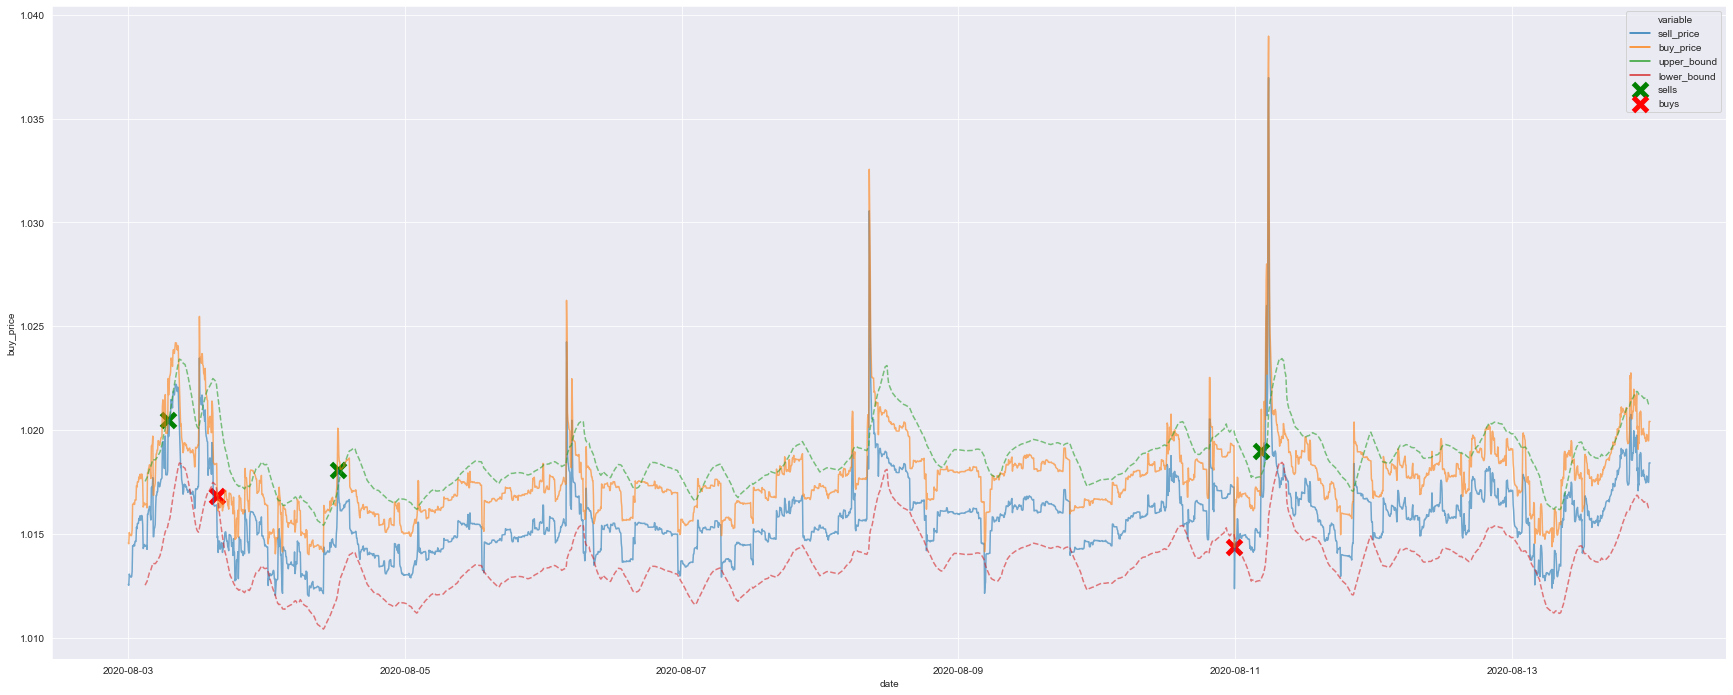

In [72]:
# Take the model for a test trive
# Initialize framework
test = create_framework(dai, .002, sell_moving_avg_type='simple', buy_moving_avg_type='simple', sell_moving_avg_hrs=3, buy_moving_avg_hrs=3, above_avg_upper_bound=.001, above_avg_lower_bound=.002, below_avg_upper_bound=.001, below_avg_lower_bound=0.002)

# Get ending balance
ending_wallet = model(test, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet')
print("Return on 1000 starting balance: ", ending_wallet)
print("ROI: ", round((ending_wallet / 1000 - 1) * 100, 1), '%' )

# Plot example trade history
log = model(test, start_coin='dai', starting_bank=1000, result_format='trade_log')
plot_trade_log(test, log)
    



We try some parameters and get a positive roi of .3%. That's better than our money does in a bank, but we can see from the chart that there are a lot of missed opportunities. Additionally, we have 8 parameters that we can adjust, most of which are continuous, which leads to infinite combinations. By visualizing the data we can see where the model shortfalls are. For example, one recurring issue we'll see as we experiment is that these large spikes up and back down pull up the moving average and cause our trader to buy back too soon as the price returns to normal when we are almost always better off waiting for the price to drop a little more. While unconventional, using a rolling median is one way to mitigate the impact of these big swings by keeping the moving average at a reasonable level, and forces our bot to wait for a cheaper price. Let's begin exploring other hyper parameters. 



Text(61.0, 0.5, 'Sell Moving Average')

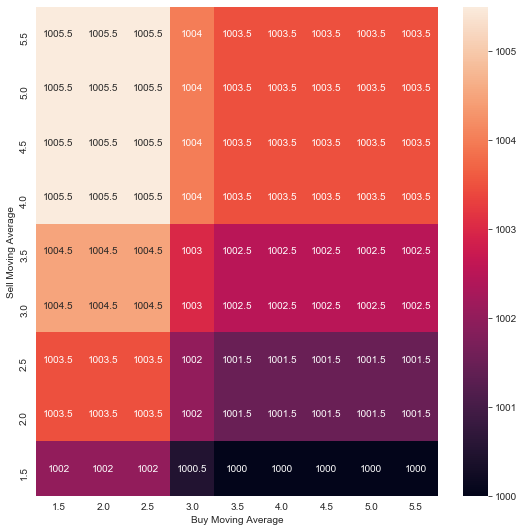

In [68]:
# Grid search hyperparameters
buy_moving_avg_hrs = [1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]
sell_moving_avg_hrs = buy_moving_avg_hrs[::-1]

col = []
for sell_hr in sell_moving_avg_hrs:
    row=[]
    for buy_hr in buy_moving_avg_hrs:
        test = create_framework(dai, .002, sell_moving_avg_type='simple', buy_moving_avg_type='simple', sell_moving_avg_hrs=sell_hr, buy_moving_avg_hrs=buy_hr, above_avg_upper_bound=.001, above_avg_lower_bound=.002, below_avg_upper_bound=.001, below_avg_lower_bound=0.002)
        row.append( model(test, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet'))
    col.append(row)

metrics_grid = pd.DataFrame(col, columns = buy_moving_avg_hrs, index = sell_moving_avg_hrs)

# Plot heatmap
plot_heatmap(metrics_grid)
plt.xlabel('Buy Moving Average')
plt.ylabel('Sell Moving Average')



We can use a heatmap to see the areas where we get the best return on our initial 1000 DAI. In this instance, we try various moving average types, while holding the other parameters constant and see that the other parameters work at their beset when the Buy Moving Average is low and the Sell Moving Average is high. This heatmap only allows us to examine two dimensions at a time however, when we have six other variables to tune. We can experiment with the heatmap to get a ballpark estimate of good parameters and dive deeper from there.



In [70]:
# Grid search for optimal parameters
results = []
for above_avg_upper_bound in [-.002, -.0015, -.001, -.005, 0, .005, .001, .0015, .002]:
    for above_avg_lower_bound in [.0015, .002, .0025, .003, .0035, .004, .0045]:
        for below_avg_upper_bound in [.0015, .002, .0025, .003, .0035, .004, .0045]:
            for below_avg_lower_bound in [-.002, -.0015, -.001, -.005, 0, .005, .001, .0015, .002]:
                dict = {}
                dict['above_upper'] = above_avg_upper_bound
                dict['above_lower'] = above_avg_lower_bound
                dict['below_upper'] = below_avg_upper_bound
                dict['below_lower'] = below_avg_lower_bound
                test = create_framework(dai, .002, sell_moving_avg_type='median', buy_moving_avg_type='simple', sell_moving_avg_hrs=4.5, buy_moving_avg_hrs=5.5, above_avg_upper_bound=above_avg_upper_bound, above_avg_lower_bound=above_avg_lower_bound, below_avg_upper_bound=below_avg_upper_bound, below_avg_lower_bound=below_avg_lower_bound)
                dict['result'] = model(test, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet')
                results.append(dict)

KeyboardInterrupt: 

In [31]:
# Show results highest returning parameters
nlargest(10, results, key=lambda item: item["result"])

[{'above_upper': -0.0015,
  'above_lower': 0.002,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1044.5},
 {'above_upper': -0.0015,
  'above_lower': 0.0025,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1044.5},
 {'above_upper': -0.0015,
  'above_lower': 0.003,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1044.5},
 {'above_upper': -0.0015,
  'above_lower': 0.0035,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1044.5},
 {'above_upper': -0.0015,
  'above_lower': 0.004,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1044.5},
 {'above_upper': -0.0015,
  'above_lower': 0.0045,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1044.5},
 {'above_upper': -0.001,
  'above_lower': 0.002,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1044.5},
 {'above_upper': -0.001,
  'above_lower': 0.0025,
  'below_upper': 0.003,
  'below_lower': 0,
  'result': 1044.5},
 {'above_upper': -0.001,
  'above_lower': 0.003,
  'below_upper': 0.003,
  'be

Return on 1000 starting balance:  1013.5
ROI:  1.4 %


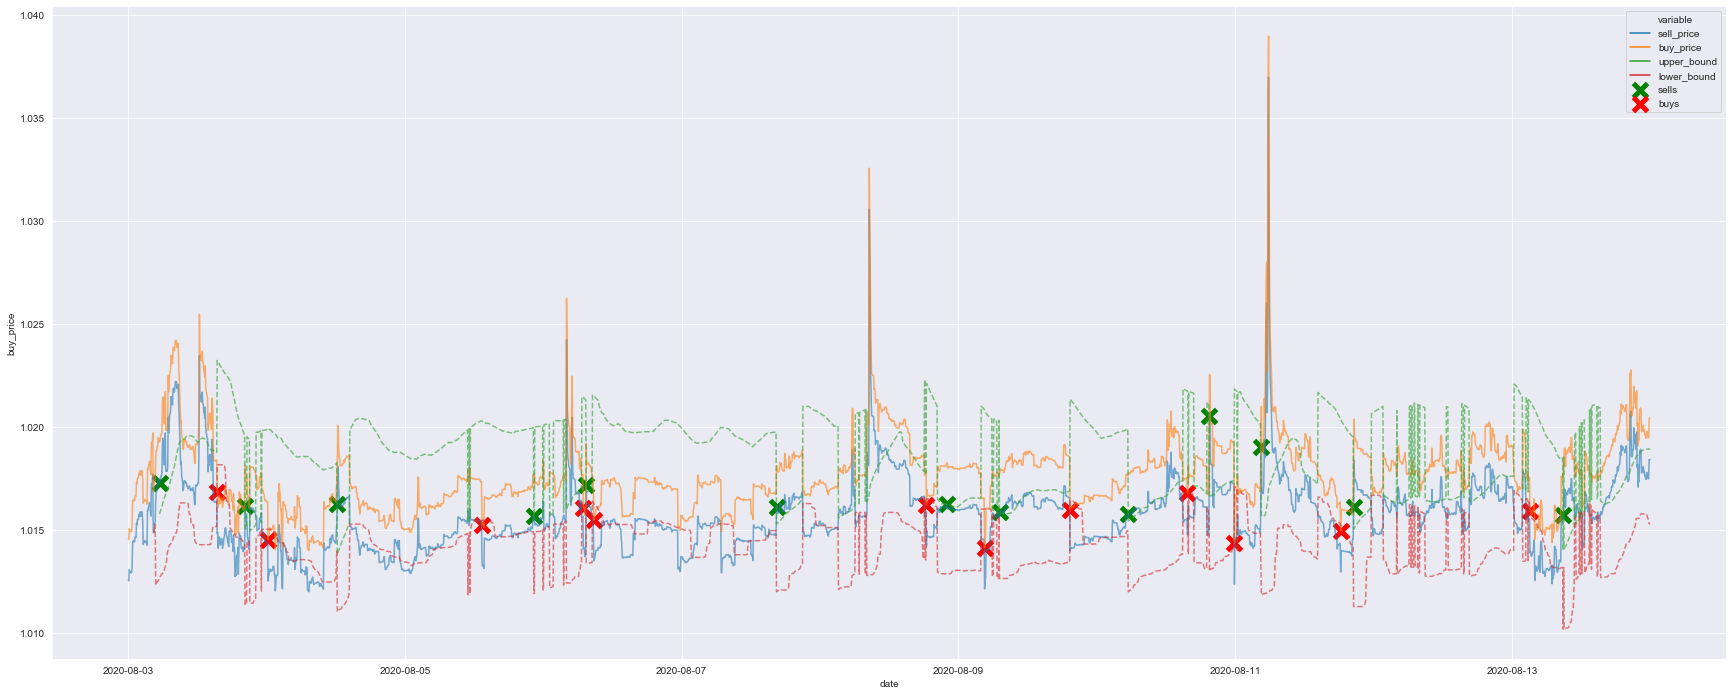

In [52]:
# Take the model for a test trive
# Initialize framework
test = create_framework(dai, .002, sell_moving_avg_type='median', buy_moving_avg_type='simple', sell_moving_avg_hrs=4.5, buy_moving_avg_hrs=5.5, above_avg_upper_bound=-0.0015, above_avg_lower_bound=.003, below_avg_upper_bound=0.003, below_avg_lower_bound=0)

# Get ending balance
ending_wallet = model(test, start_coin='cross_validate', starting_bank=1000, result_format='ending_wallet')
print("Return on 1000 starting balance: ", ending_wallet)
print("ROI: ", round((ending_wallet / 1000 - 1) * 100, 1), '%' )

# Plot example trade history
log = model(test, start_coin='dai', starting_bank=1000, result_format='trade_log')
plot_trade_log(test, log)



Our model has come a long way. Now it returns a very respectable 4.4% ROI over the same period. It is habitually able to sell high and buy low. This chart assumes we start with DAI in hand, and we see that are trades are very well timed for the most part. Let's see if the results are as successful if we happen to have started with USDC.



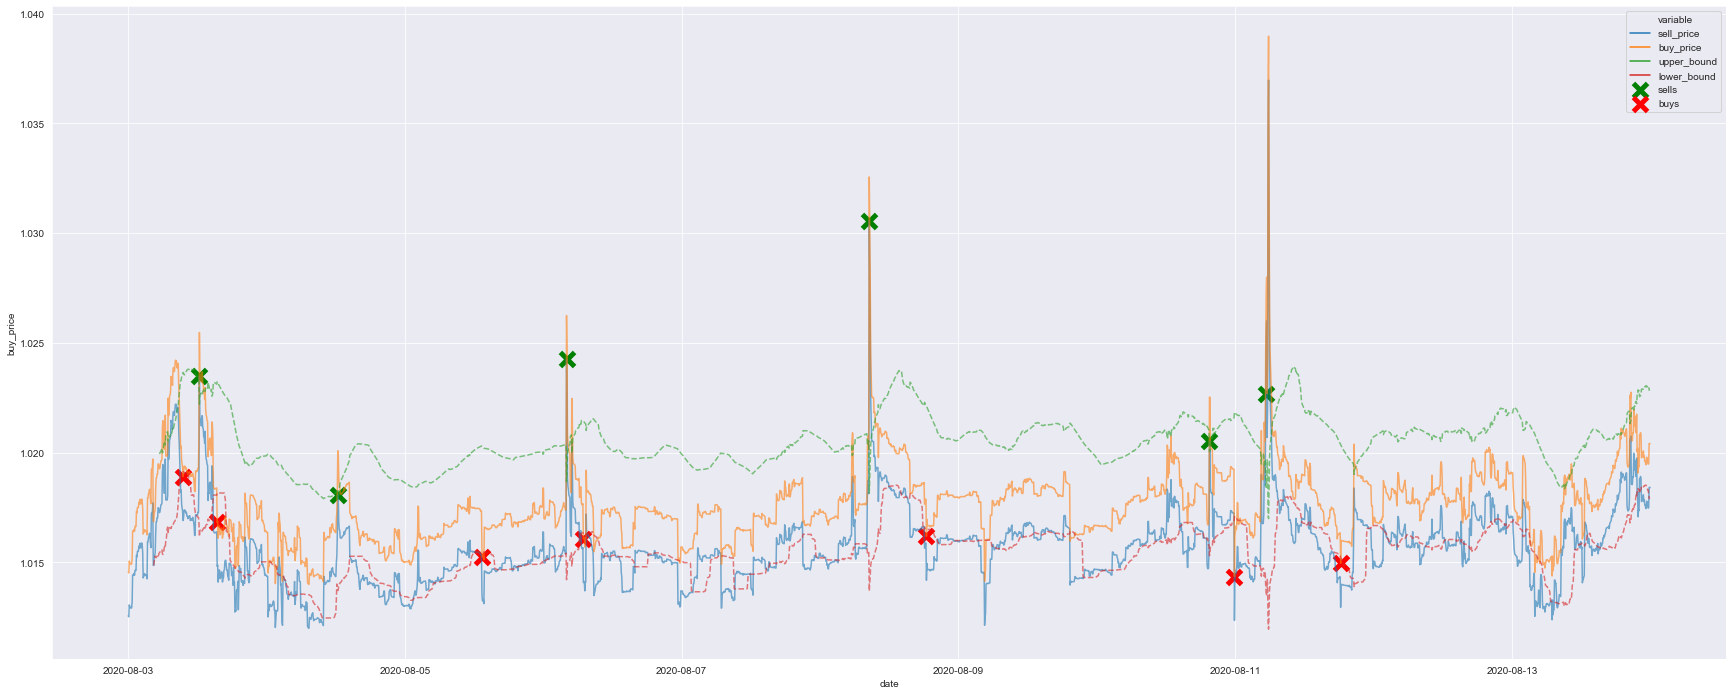

In [35]:
# Plot example trade history, this time start with USDC
log = model(test, start_coin='usdc', starting_bank=1000, result_format='trade_log')
plot_trade_log(test, log)



In fact we see our trades executing at the same spots with the exception of the first trade. Notice how the boundaries are shifted up the y axis rather than symmetrically surrounding the price. This encourages our model to be eager to buy when the price is low and puts the trader in a position to hold DAI as much as possible so it will be prepared to sell on the large up ticks. The high upper boundary causes the trader to be 'picky' about its selling points so it only sells on the big spikes to maximize gains. The only obvious failure is that the trader does not maximize gains on the largest spike, however, if our model were trained to maximize that gain, it would lose out on the smaller gains.

4% gains every 10 days is a pretty good gig, but there are some caveats. As mentioned before, our dataset is miniscule. This could be an especially good week to trade on and our model is potentially overfitting to the data. This model also doesn't account for transaction fees, but using these decentralized exchange aggregators, we are able to trade for very low fees, and when we really scale up our investment transaction fees become trivial. 

We've established a good framework to experiment with, and we will continue testing this model on future data as it becomes available, constantly adjusting it so that it performs well on seen and unseen data. There are some other improvements that can benefit the model. We'll need to eliminate the deep V's in the boundaries. This is a byproduct of having boundaries that are variable based on price. As mentioned previously, we should build in transaction costs though they should be negligible. We will also explore other data inputs that could benefit the model, things such as trading volume, total supply, current liquidity, prices of other stablecoins, even the price of bitcoin. Further we could crawl twitter for relevant tweets that may affect liquidity in the near future on the exchanges we're using. If we are able to retain long term results at a fraction of the current output, it could still be very a lucrative endeavor.

